In [2]:
import pandas as pd

In [7]:
df = pd.read_csv('data/CathEF_MHI_UCSF_2016-to-july-2022-and-2023-08-30-post-CathEF_alpha_sample.csv', sep='α')
df.Split.value_counts()
df['Outcome'] = (df['Outcome'] == 'Low EF < 40%').astype(int)
df.to_csv('data/CathEF_MHI_UCSF_2016-to-july-2022-and-2023-08-30-post-CathEF_alpha_sample.csv', sep='α', index=False)


/tmp/ipykernel_1754/816458938.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data/CathEF_MHI_UCSF_2016-to-july-2022-and-2023-08-30-post-CathEF_alpha_sample.csv', sep='α')


In [6]:

display(df.Outcome.value_counts())

Outcome
0    339
1     61
Name: count, dtype: int64

In [61]:
from sklearn.metrics import roc_curve
import numpy as np

def compute_best_threshold(
    df_gt_col: list[float], 
    df_pred_col: list[float],
) -> float:
    """
    Compute the optimal threshold for classification
    
    Args:
        df_gt_col: Ground truth labels
        df_pred_col: Predicted probabilities
        task_type: Type of classification task ('binary' or 'multiclass')
    
    Returns:
        float: Optimal threshold
    """
    fpr, tpr, thresholds = roc_curve(df_gt_col, df_pred_col)
    # Find threshold that maximizes TPR - FPR
    optimal_idx = np.argmax(tpr - fpr)
    return float(thresholds[optimal_idx])
    
def predict_main_structure(probabilities: np.ndarray) -> str:
    """
    Convert probabilities to class prediction for main structure
    
    Args:
        probabilities: Array of probabilities for each class
        
    Returns:
        str: Predicted class name
    """
    class_names = ['Left Coronary', 'Right Coronary', 'Graft', 'Catheter', 'Femoral']
    return class_names[np.argmax(probabilities)]

In [65]:
df_train = pd.read_csv('outputs/dev_deep_coro_linear_probing/mvit_pretrained_mvit_b4_f16_AdamW_lr0.0003_20250305-173253_zk0a2m13/predictions/train_predictions_epoch_4.csv')
df_val = pd.read_csv('outputs/dev_deep_coro_linear_probing/mvit_pretrained_mvit_b4_f16_AdamW_lr0.0003_20250305-173253_zk0a2m13/predictions/val_predictions_epoch_4.csv')

heads = ['contrast_agent', 'stent_presence']

prob_columns = ['main_structure_prob_Left Coronary', 'main_structure_prob_Right Coronary', 
                'main_structure_prob_Graft', 'main_structure_prob_Catheter', 
                'main_structure_prob_Femoral']

probabilities = df_val[prob_columns].values
predictions = [predict_main_structure(row) for row in probabilities]

for head in heads:
    best_threshold = compute_best_threshold(df_train[f"{head}_true"], df_train[f"{head}_pred"])
    df_val[f"{head}_pred"] = (df_val[f"{head}_pred"] > best_threshold).astype(int)
    print(f"Best threshold for {head}: {best_threshold}")
    

Best threshold for contrast_agent: 0.7676898
Best threshold for stent_presence: 0.4139509


Head: contrast_agent
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
Head: stent_presence
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


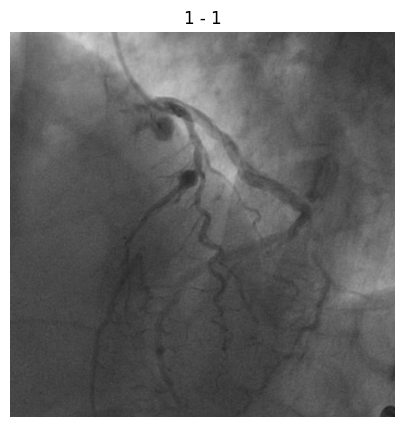

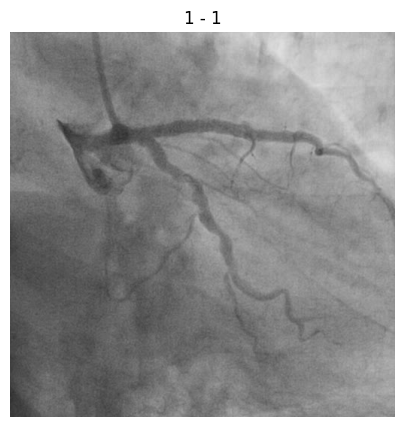

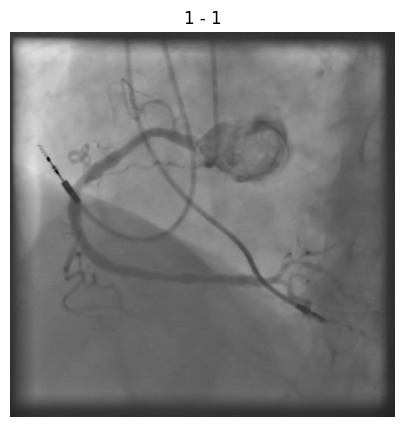

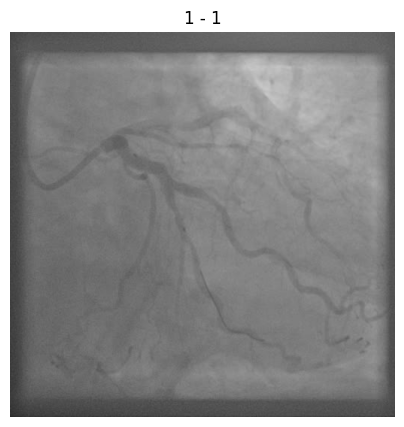

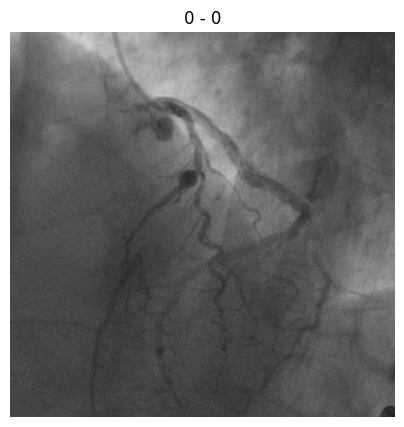

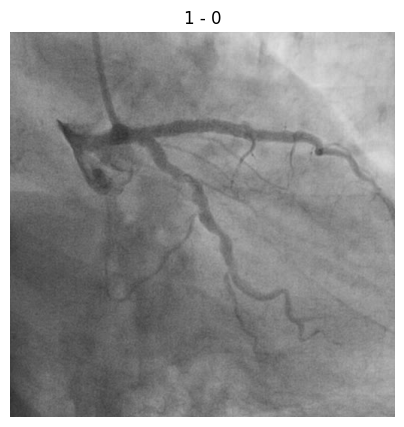

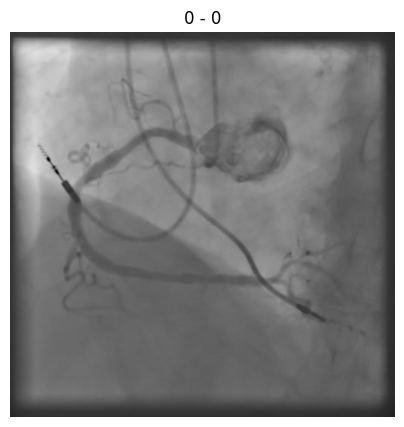

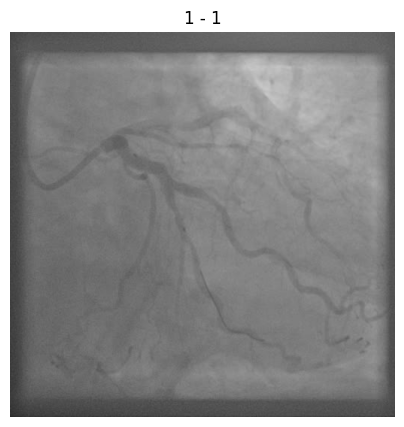

In [57]:
import os 
import sys

sys.path.append(os.path.dirname(os.path.abspath("/volume/DicomVideoProcessing/downloadAvi")))

from downloadAvi import plot_avi

random_rows = df_val.sample(n=4)

for head in heads:
    print(f"Head: {head}")
    for index, random_row in random_rows.iterrows():
        row_df = pd.DataFrame([random_row]) 
        plot_avi.sample_and_plot_middle_frames(
            row_df, N=1, 
            label_column=f'{head}_pred', 
            second_label_column=f'{head}_true',
            path_column='video_name'
        )


437

In [71]:
import cv2
import matplotlib.pyplot as plt

def plot_middle_frame_main_structure(video_path: str, probabilities: np.ndarray, ground_truth: str) -> None:
    """
    Plot the middle frame of a video with main structure prediction and ground truth.
    
    Args:
        video_path (str): Path to the video file
        probabilities (np.ndarray): Array of probabilities for each class
        ground_truth (str): Ground truth class name
    """
    # Open video and get middle frame
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {video_path}")
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    middle_frame_idx = total_frames // 2
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        raise ValueError(f"Could not read frame {middle_frame_idx} from video: {video_path}")
    
    # Convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Get prediction
    class_names = ['Left Coronary', 'Right Coronary', 'Graft', 'Catheter', 'Femoral']
    pred_class = predict_main_structure(probabilities)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    plt.imshow(frame)
    
    # Create title with prediction, ground truth and color coding
    title = f'Predicted: {pred_class}\nGround Truth: {ground_truth}\n'
    title += 'Probabilities:\n' + '\n'.join([f'{name}: {prob:.3f}' for name, prob in zip(class_names, probabilities)])
    
    # Add color coding to indicate correct/incorrect prediction
    if pred_class == ground_truth:
        plt.gca().set_title(title, color='green')
    else:
        plt.gca().set_title(title, color='red')
    
    plt.axis('off')
    plt.show()

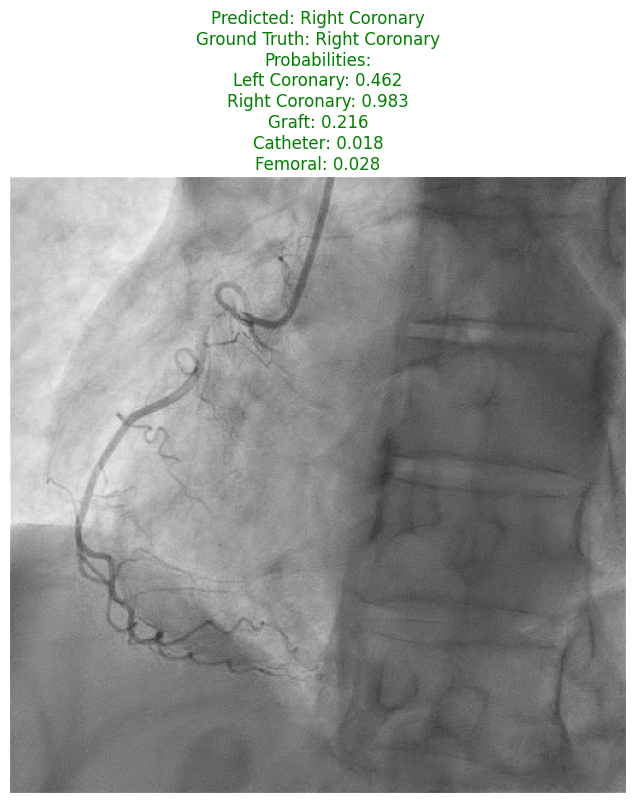

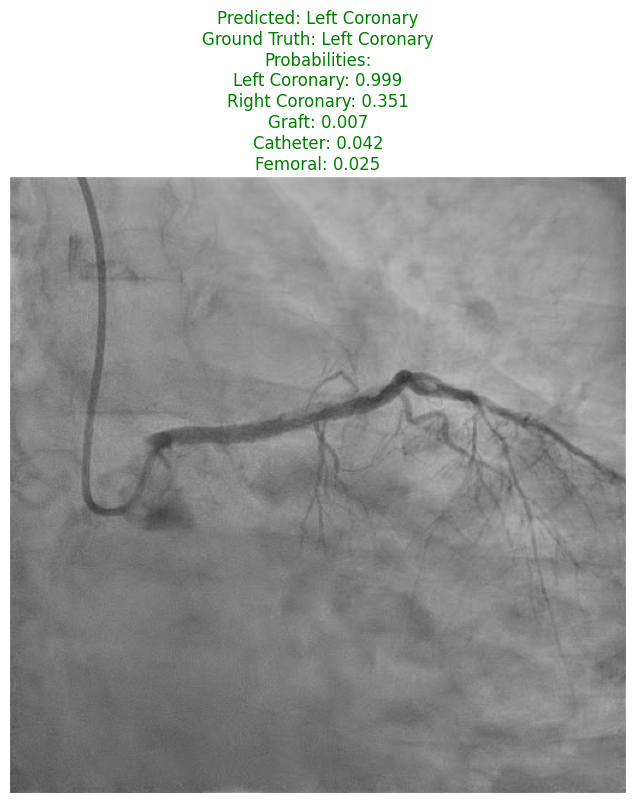

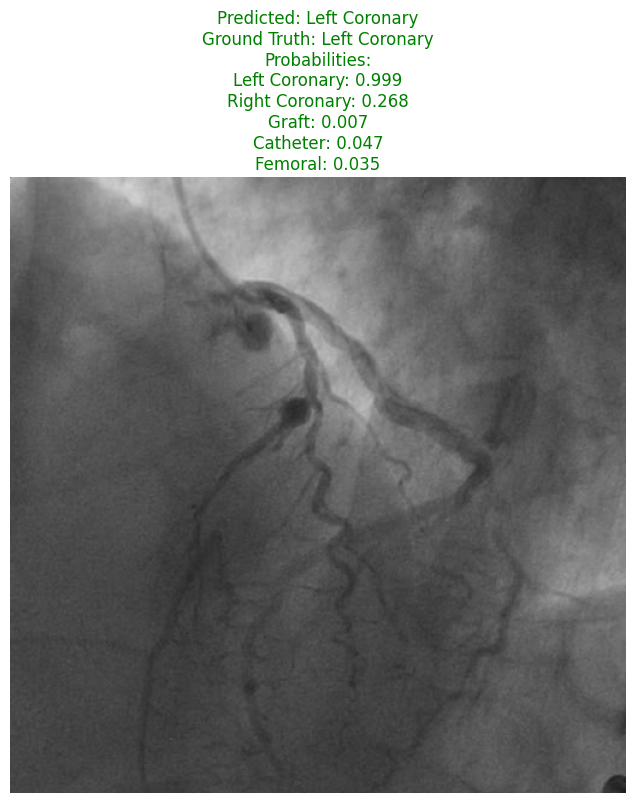

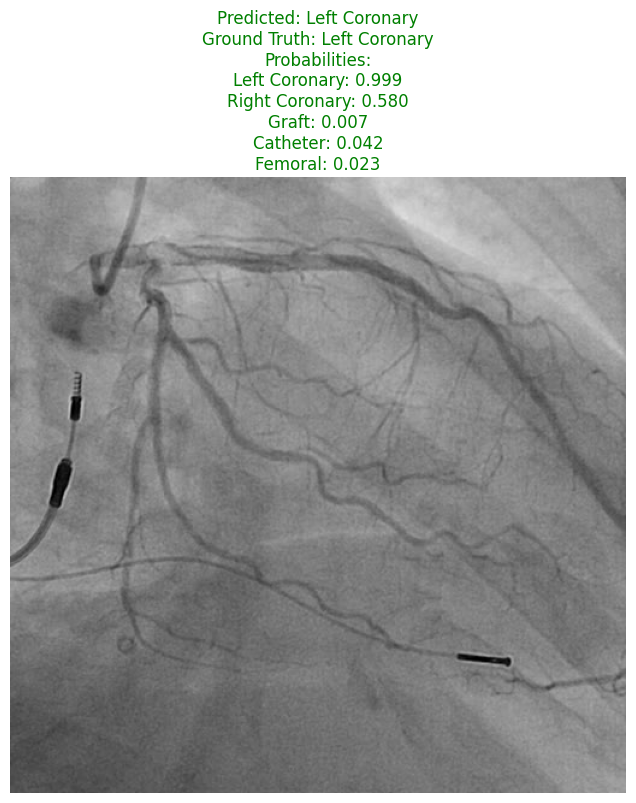

In [72]:
# Example usage
random_rows = df_val.sample(n=4)
prob_columns = ['main_structure_prob_Left Coronary', 'main_structure_prob_Right Coronary', 
                'main_structure_prob_Graft', 'main_structure_prob_Catheter', 
                'main_structure_prob_Femoral']

for _, row in random_rows.iterrows():
    probabilities = [row[col] for col in prob_columns]
    plot_middle_frame_main_structure(
        video_path=row['video_name'],
        probabilities=np.array(probabilities),
        ground_truth=row['main_structure_true_class']
    )